# Part 3: Compression

In [49]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os
os.environ['PATH'] = '/home/bcilab/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']

## Fetch the jet tagging dataset from Open ML

In [50]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

In [51]:
DATA_DIR = 'npy'
MODEL_DIR = 'model'

BOARD_NAME = 'ultra96v2'
FPGA_PART = 'xczu3eg-sbva484-1-i' 

CLOCK_PERIOD = 10

## Now construct a model
We'll use the same architecture as in part 1: 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [53]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

## Train sparse
This time we'll use the Tensorflow model optimization sparsity to train a sparse model (forcing many weights to '0'). In this instance, the target sparsity is 75%

In [54]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

/home/bcilab/anaconda3/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:212: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  mask = self.add_variable(
/home/bcilab/anaconda3/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:219: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  threshold = self.add_variable(
/home/bcilab/anaconda3/lib/python3.8/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:233: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.pruning_step = self.add_variable(


## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [55]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_2')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model_2/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    model = load_model('model_2/KERAS_check_best_model.h5')

/home/bcilab/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
469/487 [===========================>..] - ETA: 0s - loss: 1.3366 - accuracy: 0.5117
***callbacks***
saving losses to model_2/losses.log

Epoch 00001: val_loss improved from inf to 1.12515, saving model to model_2/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 1.12515, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model_2/KERAS_check_model_last.h5

Epoch 00001: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 77s 12ms/step - loss: 1.3290 - accuracy: 0.5161 - val_loss: 1.1252 - val_accuracy: 0.6363 - lr: 1.0000e-04
Epoch 2/30
464/487 [===========================>..] - ETA: 0s - loss: 1.0576 - accuracy: 0.6657
***callbacks***
saving losses to model_2/losses.log

Epoch 00002: val_loss improved from 1.12515 to 1.00706, saving model to model_2/KERAS_check_best_model.h5

Epoch 00002: val_loss improved from 1.12515 to 1.00706, saving model to mo

Epoch 14/30
485/487 [============================>.] - ETA: 0s - loss: 0.8150 - accuracy: 0.7282
***callbacks***
saving losses to model_2/losses.log

Epoch 00014: val_loss improved from 0.82229 to 0.81568, saving model to model_2/KERAS_check_best_model.h5

Epoch 00014: val_loss improved from 0.82229 to 0.81568, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 00014: saving model to model_2/KERAS_check_model_last.h5

Epoch 00014: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 0.8150 - accuracy: 0.7282 - val_loss: 0.8157 - val_accuracy: 0.7286 - lr: 1.0000e-04
Epoch 15/30
476/487 [============================>.] - ETA: 0s - loss: 0.8089 - accuracy: 0.7298
***callbacks***
saving losses to model_2/losses.log

Epoch 00015: val_loss improved from 0.81568 to 0.80985, saving model to model_2/KERAS_check_best_model.h5

Epoch 00015: val_loss improved from 0.81568 to 0.80985, saving mod

486/487 [============================>.] - ETA: 0s - loss: 0.7654 - accuracy: 0.7420
***callbacks***
saving losses to model_2/losses.log

Epoch 00026: val_loss improved from 0.77129 to 0.76874, saving model to model_2/KERAS_check_best_model.h5

Epoch 00026: val_loss improved from 0.77129 to 0.76874, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 00026: saving model to model_2/KERAS_check_model_last.h5

Epoch 00026: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.7654 - accuracy: 0.7419 - val_loss: 0.7687 - val_accuracy: 0.7415 - lr: 1.0000e-04
Epoch 27/30
464/487 [===========================>..] - ETA: 0s - loss: 0.7629 - accuracy: 0.7429
***callbacks***
saving losses to model_2/losses.log

Epoch 00027: val_loss improved from 0.76874 to 0.76652, saving model to model_2/KERAS_check_best_model.h5

Epoch 00027: val_loss improved from 0.76874 to 0.76652, saving model to model_

## Check sparsity
Make a quick check that the model was indeed trained sparse. We'll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing '0'. Note logarithmic y axis.

% of zeros = 0.75


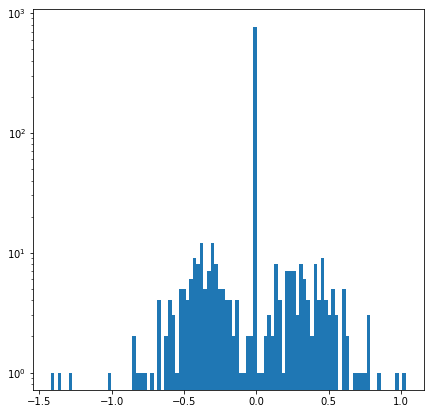

In [56]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))

## Check performance
How does this 75% sparse model compare against the unpruned model? Let's report the accuracy and make a ROC curve. The pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.
**Make sure you've trained the model from part 1**

Accuracy unpruned: 0.7502530120481927
Accuracy pruned:   0.7430963855421687


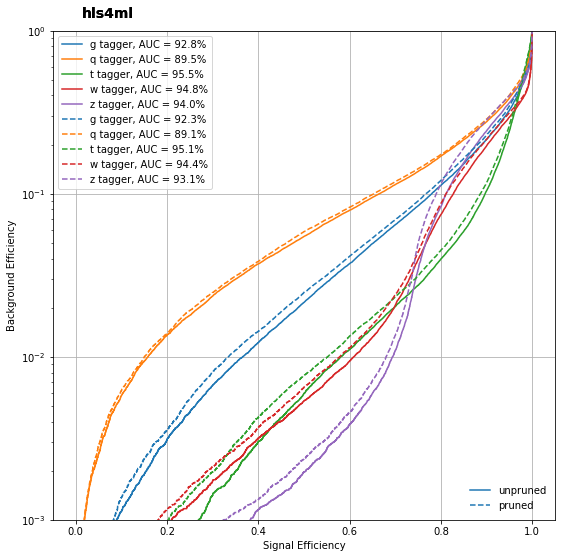

In [57]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
model_ref = load_model('model_1/KERAS_check_best_model.h5')

y_ref = model_ref.predict(X_test)
y_prune = model.predict(X_test)

print("Accuracy unpruned: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_prune, classes, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['unpruned', 'pruned'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

# Convert the model to FPGA firmware with hls4ml
Let's use the default configuration: `ap_fixed<16,6>` precision everywhere and `ReuseFactor=1`, so we can compare with the part 1 model. We need to use `strip_pruning` to change the layer types back to their originals.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_2/hls4ml_prj/vivado_hls.log`

In [58]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print(config)
hls_model = hls4ml.converters.convert_from_keras_model(model=model,
                                     clock_period=CLOCK_PERIOD,
                                     backend='VivadoAccelerator',
                                     board=BOARD_NAME,
                                     part=FPGA_PART,
                                     io_type='io_stream',
                                     interface='axi_stream',
                                     driver='c',
                                     hls_config=config,
                                     output_dir='model_2/hls4ml_prj')
hls_model.compile()

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, in

In [59]:
hls_model.build(csim=False, synth=True, export=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/bcilab/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/bcilab/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'bcilab' on host 'bcilab-rrid411' (Linux_x86_64 version 4.15.0-188-generic) on Wed Jul 13 09:54:40 IST 2022
INFO: [HLS 200-10] On os Ubuntu 18.04.6 LTS
INFO: [HLS 200-10] In directory '/home/bcilab/NN_fpga/hls4ml-tutorial/model_2/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/bcilab/NN_fpga/hls4ml-tutorial/model_2/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the project
INFO: [HLS 200-10]

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:31 ; elapsed = 00:00:41 . Memory (MB): peak = 901.930 ; gain = 200.645 ; free physical = 1315 ; free virtual = 13455
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.1/continuous/2019_05_24_2552052/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.1/continuous/2019_05_24_2552052/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.1/continuous/2019_05_24_2552052/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:59

INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::softmax_latency<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 5u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 5u>, softmax_config13>' (firmware/nnet_utils/nnet_activation_stream.h:32:59).
INFO: [XFORM 203-502] Unrolling small iteration loop 'Loop-1' (firmware/myproject_axi.cpp:23) in function 'myproject_axi' automatically.
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_wrapper<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>' (firmware/nnet_utils/nnet_dense_latency.h:20:55).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_wrapper<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10>' (firmware/nnet_utils/nnet_dense_latency.h:20:55).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet

INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_latency.h:120) in function 'nnet::dense_wrapper<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config10>' completely with a factor of 32.
INFO: [HLS 200-489] Unrolling loop 'Product1' (firmware/nnet_utils/nnet_dense_latency.h:85) in function 'nnet::dense_wrapper<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config7>' completely with a factor of 64.
INFO: [HLS 200-489] Unrolling loop 'Product2' (firmware/nnet_utils/nnet_dense_latency.h:90) in function 'nnet::dense_wrapper<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config7>' completely with a factor of 32.
INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:101) in function 'nnet::dense_wrapper<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o

INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.1/continuous/2019_05_24_2552052/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:59) automatically.
INFO: [XFORM 203-602] Inlining function 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' into 'generic_cast_IEEE754<int, double>' (/wrk/2019.1/continuous/2019_05_24_2552052/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:117) automatically.
INFO: [XFORM 203-602] Inlining function 'generic_cast_IEEE754<int, double>' into '__hls_fptosi_double_i32' (/wrk/2019.1/continuous/2019_05_24_2552052/src/products/hls/hls_lib/hlsmath/src/lib_floatconversion.cpp:55) automatically.
INFO: [XFORM 203-602] Inlining function '__hls_fptosi_double_i32' into 'nnet::dense_wrapper<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' (firmware/nnet_utils/nnet_dense_latency.h:

INFO: [XFORM 203-11] Balancing expressions in function 'nnet::softmax_latency<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 5u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 5u>, softmax_config13>' (firmware/nnet_utils/nnet_activation_stream.h:34:1)...4 expression(s) balanced.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_wrapper<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config7>' (firmware/nnet_utils/nnet_mult.h:20:9)...511 expression(s) balanced.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_wrapper<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' (firmware/nnet_utils/nnet_mult.h:20:9)...235 expression(s) balanced.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_wrapper<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>' (firmwar

INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 1.33 seconds; current allocated memory: 483.200 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_array_array_ap_fixed_16_6_5_3_0_64u_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.2 seconds; current allocated memory: 484.157 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.26 seconds; current allocated memory: 485.244 MB.
INFO: [HLS 200-10] -----------------------------------------

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 3.8 seconds; current allocated memory: 548.056 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'Block_myproject_axi_exit346_proc261' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 2.55 seconds; current allocated memory: 550.220 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-10

INFO: [SYN 201-210] Renamed object name 'start_for_dense_array_array_ap_fixed_16_6_5_3_0_32u_config7_U0' to 'start_for_dense_array_array_ap_fixed_16_6_5_3_0_32u_conficud' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'start_for_dense_array_array_ap_fixed_16_6_5_3_0_32u_config10_U0' to 'start_for_dense_array_array_ap_fixed_16_6_5_3_0_32u_confidEe' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'start_for_dense_array_array_ap_fixed_16_6_5_3_0_5u_config11_U0' to 'start_for_dense_array_array_ap_fixed_16_6_5_3_0_5u_configeOg' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'start_for_softmax_array_array_ap_fixed_5u_softmax_config13_U0' to 'start_for_softmax_array_array_ap_fixed_5u_softmax_config1fYi' due to the length limit 60
INFO: [RTGEN 206-100] Finished creating RTL model for 'myproject'.
INFO: [HLS 200-111]  Elapsed time: 2.48 seconds; current allocated memory: 716.176 MB.
INFO: [HLS 200-10] -----------------------------------

***** EXPORT IP COMPLETED IN 0h0m46s *****
INFO: [HLS 200-112] Total elapsed time: 305.84 seconds; peak allocated memory: 725.782 MB.
INFO: [Common 17-206] Exiting vivado_hls at Wed Jul 13 09:59:44 2022...


{'EstimatedClockPeriod': '8.716',
 'BestLatency': '49',
 'WorstLatency': '49',
 'IntervalMin': '50',
 'IntervalMax': '50',
 'BRAM_18K': '4',
 'DSP48E': '914',
 'FF': '3940',
 'LUT': '44605',
 'URAM': '0',
 'AvailableBRAM_18K': '432',
 'AvailableDSP48E': '360',
 'AvailableFF': '141120',
 'AvailableLUT': '70560',
 'AvailableURAM': '0'}

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [60]:
hls4ml.report.read_vivado_report('model_2/hls4ml_prj/')

Found 1 solution(s) in model_2/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject_axi'
* Date:           Wed Jul 13 09:58:46 2022

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu3eg-sbva484-1-e


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |  10.00|     8.716|        1.25|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   49|   49|   50|   50| dataflow |
    +-----+-----+-----+-----+--

Print the report for the model trained in part 1. Remember these models have the same architecture, but the model in this section was trained using the sparsity API from tensorflow_model_optimization. Notice how the resource usage had dramatically reduced (particularly the DSPs). When Vivado HLS notices an operation like `y = 0 * x` it can avoid placing a DSP for that operation. The impact of this is biggest when `ReuseFactor = 1`, but still applies at higher reuse as well. **Note you need to have trained and synthesized the model from part 1**

In [61]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Found 1 solution(s) in model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject_axi'
* Date:           Mon Jul 11 11:07:01 2022

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu3eg-sbva484-1-e


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |  10.00|     8.716|        1.25|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   75|   76|   66|   67| dataflow |
    +-----+-----+-----+-----+---